In [1]:
import sys,os
sys.path.append('..')
sys.path.append('../..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.swarms.manager import SwarmManager
from backtester.exoinfo import EXOInfo

import pandas as pd
import numpy as np
import scipy

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [3]:
swarms = {}
for file in os.listdir('./temp_swarms/'):
    swarm_name = file.replace('.swm','')
    swarms[swarm_name] = SwarmManager.load(os.path.join('temp_swarms', file))

In [4]:
campaign_dict = {}
for swarm_name, smgr in swarms.items():
        smgr = swarms[swarm_name]
        campaign_dict[swarm_name] = smgr.swarm_picked.sum(axis=1)
   
    
campaign_portfolio = pd.DataFrame(campaign_dict)

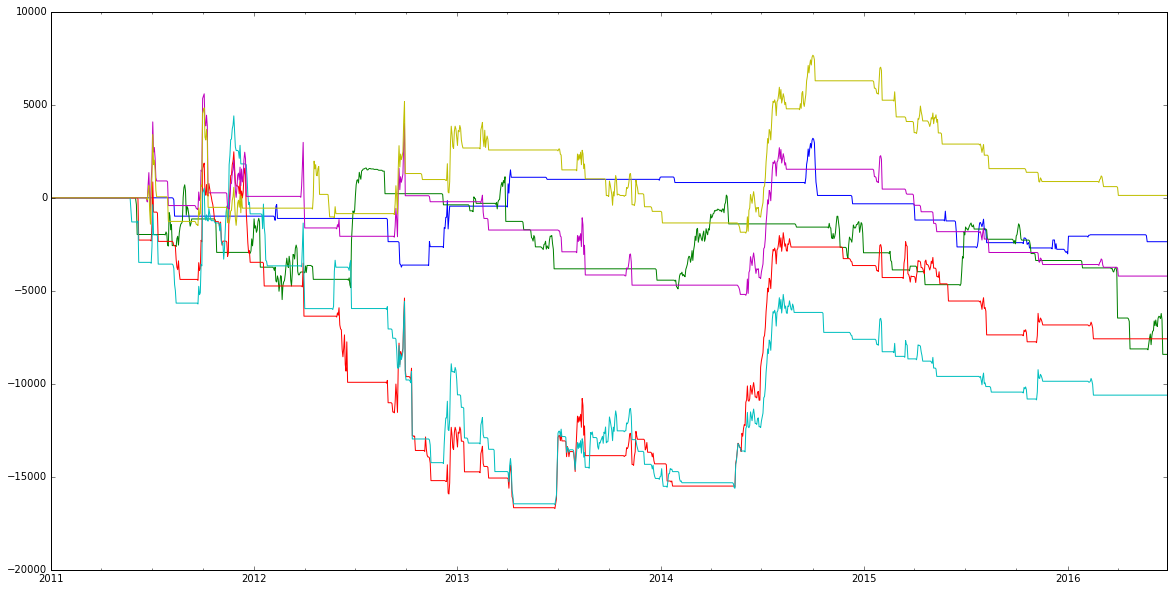

In [5]:
figsize(20,10)
campaign_portfolio.plot(legend=False)

## Rng strategies

In [6]:
#
# random time series
#
df = pd.DataFrame()
for i in range(100):
    
    date = pd.date_range(start='2015-01', end='2016-10', freq='D')
    price = np.random.randint(-100, 101, size=len(date))
    
    ser = pd.Series(price, index=date, name='rng_system'+str(i))
    df['rng_system'+str(i)] = ser.cumsum()

## Select input DF. Real swarms or RNG pseudo strategies

In [41]:
# Real swarms
#df = campaign_portfolio

# Rng strategies
#df = df

# Real swarms from DF
df = pd.read_csv('./swarms_df/ichi_swarm_1.csv', parse_dates=[0],
                dayfirst=True, index_col=0).asfreq('D')

In [42]:
df.columns

Index(['(1, 5, 26, 26, 40, 0, 1)', '(1, 5, 26, 26, 40, 0, 11)',
       '(1, 5, 26, 26, 40, 0, 13)', '(1, 5, 26, 26, 40, 0, 15)',
       '(1, 5, 26, 26, 40, 0, 17)', '(1, 5, 26, 26, 40, 0, 19)',
       '(1, 5, 26, 26, 40, 0, 21)', '(1, 5, 26, 26, 40, 0, 3)',
       '(1, 5, 26, 26, 40, 0, 5)', '(1, 5, 26, 26, 40, 0, 7)',
       ...
       '(1, 5, 26, 26, 70, 9, 11)', '(1, 5, 26, 26, 70, 9, 13)',
       '(1, 5, 26, 26, 70, 9, 15)', '(1, 5, 26, 26, 70, 9, 17)',
       '(1, 5, 26, 26, 70, 9, 19)', '(1, 5, 26, 26, 70, 9, 21)',
       '(1, 5, 26, 26, 70, 9, 3)', '(1, 5, 26, 26, 70, 9, 5)',
       '(1, 5, 26, 26, 70, 9, 7)', '(1, 5, 26, 26, 70, 9, 9)'],
      dtype='object', length=748)

In [43]:
#df.plot()

## Systems overall performance estimation

In [44]:
temp_l = []

for strat in df.columns:

        input_strategy_data = df[strat] # This data is used in metrics calc

        price_change = input_strategy_data.diff()
        max_dd = (input_strategy_data - input_strategy_data.expanding().max()).min()
        netprofit = df[strat].ix[-1] - df[strat].ix[0]

        # Since swarm PnL statistics is not trade-by-trade
        # For PF calc I used cumulative values of positive and negatives price changes
        # Same for winrate
        profit_factor = price_change[price_change > 0].sum() / np.abs(price_change[price_change < 0].sum())

        winrate = (price_change[price_change > 0].count() / price_change.count()) * 100               

        modsharpe = np.mean(price_change) / np.std(price_change)

        d = {'strategy': strat,
            'stats_pricechange_modsharpe': modsharpe, 
            'stats_netprofit': netprofit,
            'stats_max_dd': max_dd, 'stats_recovery_factor': netprofit / np.abs(max_dd),
            'stats_profit_factor': profit_factor, 'stats_winrate': winrate }

        temp_l.append(d)      

In [45]:
strategies_performance_df = pd.DataFrame(temp_l).ix[:]
strategies_performance_df['rank_score'] = np.zeros_like(len(strategies_performance_df))
strategies_performance_df

,stats_max_dd,stats_netprofit,stats_pricechange_modsharpe,stats_profit_factor,stats_recovery_factor,stats_winrate,strategy,rank_score
0,-3547.50,-1582.00,-0.001741,0.991187,-0.445948,13.874346,"(1, 5, 26, 26, 40, 0, 1)",0
1,-5762.25,-3801.50,-0.032109,0.863596,-0.659725,18.150087,"(1, 5, 26, 26, 40, 0, 11)",0
2,-6724.75,-3051.50,-0.031564,0.866574,-0.453772,18.586387,"(1, 5, 26, 26, 40, 0, 13)",0
3,-5024.50,-2423.25,-0.026410,0.890529,-0.482287,20.506108,"(1, 5, 26, 26, 40, 0, 15)",0
4,-6485.50,-3937.25,-0.033485,0.860339,-0.607085,19.546248,"(1, 5, 26, 26, 40, 0, 17)",0
5,-6541.00,-3992.75,-0.035381,0.853369,-0.610419,19.633508,"(1, 5, 26, 26, 40, 0, 19)",0
6,-7480.00,-5056.75,-0.039516,0.837924,-0.676036,19.720768,"(1, 5, 26, 26, 40, 0, 21)",0
7,-5076.25,-3549.50,-0.031057,0.860618,-0.699237,15.270506,"(1, 5, 26, 26, 40, 0, 3)",0
8,-6606.50,-5490.50,-0.046676,0.798735,-0.831075,15.794066,"(1, 5, 26, 26, 40, 0, 5)",0
9,-6608.50,-4491.50,-0.038844,0.834262,-0.679655,17.452007,"(1, 5, 26, 26, 40, 0, 7)",0


## Strategies overall performance ranking

In [46]:
ranks_d = {}

for col in strategies_performance_df.columns:
    
    stats_col_flag = False
    
    if 'stats' in col:

        # Define 0-10-20-30-40-50-60-70-80-90-100 quantiles values of certain strategy statistics
        metric_quantile0 = strategies_performance_df[col].quantile(0.0)
        metric_quantile10 = strategies_performance_df[col].quantile(0.1)
        metric_quantile20 = strategies_performance_df[col].quantile(0.2)
        metric_quantile30 = strategies_performance_df[col].quantile(0.3)
        metric_quantile40 = strategies_performance_df[col].quantile(0.4)
        metric_quantile50 = strategies_performance_df[col].quantile(0.5)
        metric_quantile60 = strategies_performance_df[col].quantile(0.6)
        metric_quantile70 = strategies_performance_df[col].quantile(0.7)
        metric_quantile80 = strategies_performance_df[col].quantile(0.8)
        metric_quantile90 = strategies_performance_df[col].quantile(0.9)
        metric_quantile100 = strategies_performance_df[col].quantile(1)
        
        stats_col_flag = True
    
    if stats_col_flag == True:
        
        for strat in strategies_performance_df.strategy:
        
            # Define strategy statistics rank of certain strategy

            strategy_stats_metric = strategies_performance_df[strategies_performance_df.strategy == strat][col].values[0]

            if strategy_stats_metric >= metric_quantile0 and strategy_stats_metric <= metric_quantile10:
                rank_score = 0

            elif strategy_stats_metric >= metric_quantile10 and strategy_stats_metric <= metric_quantile20:
                rank_score = 1

            elif strategy_stats_metric >= metric_quantile20 and strategy_stats_metric <= metric_quantile30:
                rank_score = 2

            elif strategy_stats_metric >= metric_quantile30 and strategy_stats_metric <= metric_quantile40:
                rank_score = 3

            elif strategy_stats_metric >= metric_quantile40 and strategy_stats_metric <= metric_quantile50:
                rank_score = 4

            elif strategy_stats_metric >= metric_quantile50 and strategy_stats_metric <= metric_quantile60:
                rank_score = 5

            elif strategy_stats_metric >= metric_quantile60 and strategy_stats_metric <= metric_quantile70:
                rank_score = 6

            elif strategy_stats_metric >= metric_quantile70 and strategy_stats_metric <= metric_quantile80:
                rank_score = 7

            elif strategy_stats_metric >= metric_quantile80 and strategy_stats_metric <= metric_quantile90:
                rank_score = 8

            elif strategy_stats_metric >= metric_quantile90 and strategy_stats_metric <= metric_quantile100:
                rank_score = 9

            elif strategy_stats_metric == metric_quantile100:
                rank_score = 10

                
            if strat not in ranks_d.keys():               
                ranks_d[strat] = rank_score
                
            elif strat in ranks_d.keys():                
                ranks_d[strat] = ranks_d[strat] + rank_score
                          
            # For debugging purposes

            #print('strategy---',strat,'\n')
            #print(col)
            #print('10 quantile---',metric_quantile10)
            #print(strategy_stats_metric)
            #print('60 quantile---',metric_quantile60)
            #print(strategy_stats_metric > metric_quantile40 and strategy_stats_metric < metric_quantile50)
            #print('rank_score------', rank_score, '\n')

        #print("NEXT----------------------- \n")

# Set rank scores for strategies from dict

for k in ranks_d:
    
    strat_index = strategies_performance_df[strategies_performance_df.strategy == k].index
    strategies_performance_df = strategies_performance_df.set_value(strat_index, 'rank_score', ranks_d[k])

In [47]:
strategies_performance_df

,stats_max_dd,stats_netprofit,stats_pricechange_modsharpe,stats_profit_factor,stats_recovery_factor,stats_winrate,strategy,rank_score
0,-3547.50,-1582.00,-0.001741,0.991187,-0.445948,13.874346,"(1, 5, 26, 26, 40, 0, 1)",39
1,-5762.25,-3801.50,-0.032109,0.863596,-0.659725,18.150087,"(1, 5, 26, 26, 40, 0, 11)",25
2,-6724.75,-3051.50,-0.031564,0.866574,-0.453772,18.586387,"(1, 5, 26, 26, 40, 0, 13)",27
3,-5024.50,-2423.25,-0.026410,0.890529,-0.482287,20.506108,"(1, 5, 26, 26, 40, 0, 15)",32
4,-6485.50,-3937.25,-0.033485,0.860339,-0.607085,19.546248,"(1, 5, 26, 26, 40, 0, 17)",25
5,-6541.00,-3992.75,-0.035381,0.853369,-0.610419,19.633508,"(1, 5, 26, 26, 40, 0, 19)",25
6,-7480.00,-5056.75,-0.039516,0.837924,-0.676036,19.720768,"(1, 5, 26, 26, 40, 0, 21)",20
7,-5076.25,-3549.50,-0.031057,0.860618,-0.699237,15.270506,"(1, 5, 26, 26, 40, 0, 3)",25
8,-6606.50,-5490.50,-0.046676,0.798735,-0.831075,15.794066,"(1, 5, 26, 26, 40, 0, 5)",14
9,-6608.50,-4491.50,-0.038844,0.834262,-0.679655,17.452007,"(1, 5, 26, 26, 40, 0, 7)",21


## Drop all strategies which have rank score less than n quantile value 

In [48]:
df = df[strategies_performance_df[strategies_performance_df.rank_score >= strategies_performance_df.rank_score.quantile(0.7)].strategy]

In [49]:
df.columns

Index(['(1, 5, 26, 26, 40, 0, 1)', '(1, 5, 26, 26, 40, 10, 1)',
       '(1, 5, 26, 26, 40, 10, 11)', '(1, 5, 26, 26, 40, 10, 13)',
       '(1, 5, 26, 26, 40, 10, 17)', '(1, 5, 26, 26, 40, 10, 19)',
       '(1, 5, 26, 26, 40, 10, 21)', '(1, 5, 26, 26, 40, 10, 9)',
       '(1, 5, 26, 26, 40, 11, 19)', '(1, 5, 26, 26, 40, 11, 21)',
       ...
       '(1, 5, 26, 26, 70, 5, 9)', '(1, 5, 26, 26, 70, 6, 1)',
       '(1, 5, 26, 26, 70, 6, 3)', '(1, 5, 26, 26, 70, 8, 1)',
       '(1, 5, 26, 26, 70, 8, 11)', '(1, 5, 26, 26, 70, 8, 13)',
       '(1, 5, 26, 26, 70, 8, 17)', '(1, 5, 26, 26, 70, 8, 19)',
       '(1, 5, 26, 26, 70, 8, 21)', '(1, 5, 26, 26, 70, 8, 9)'],
      dtype='object', length=234)

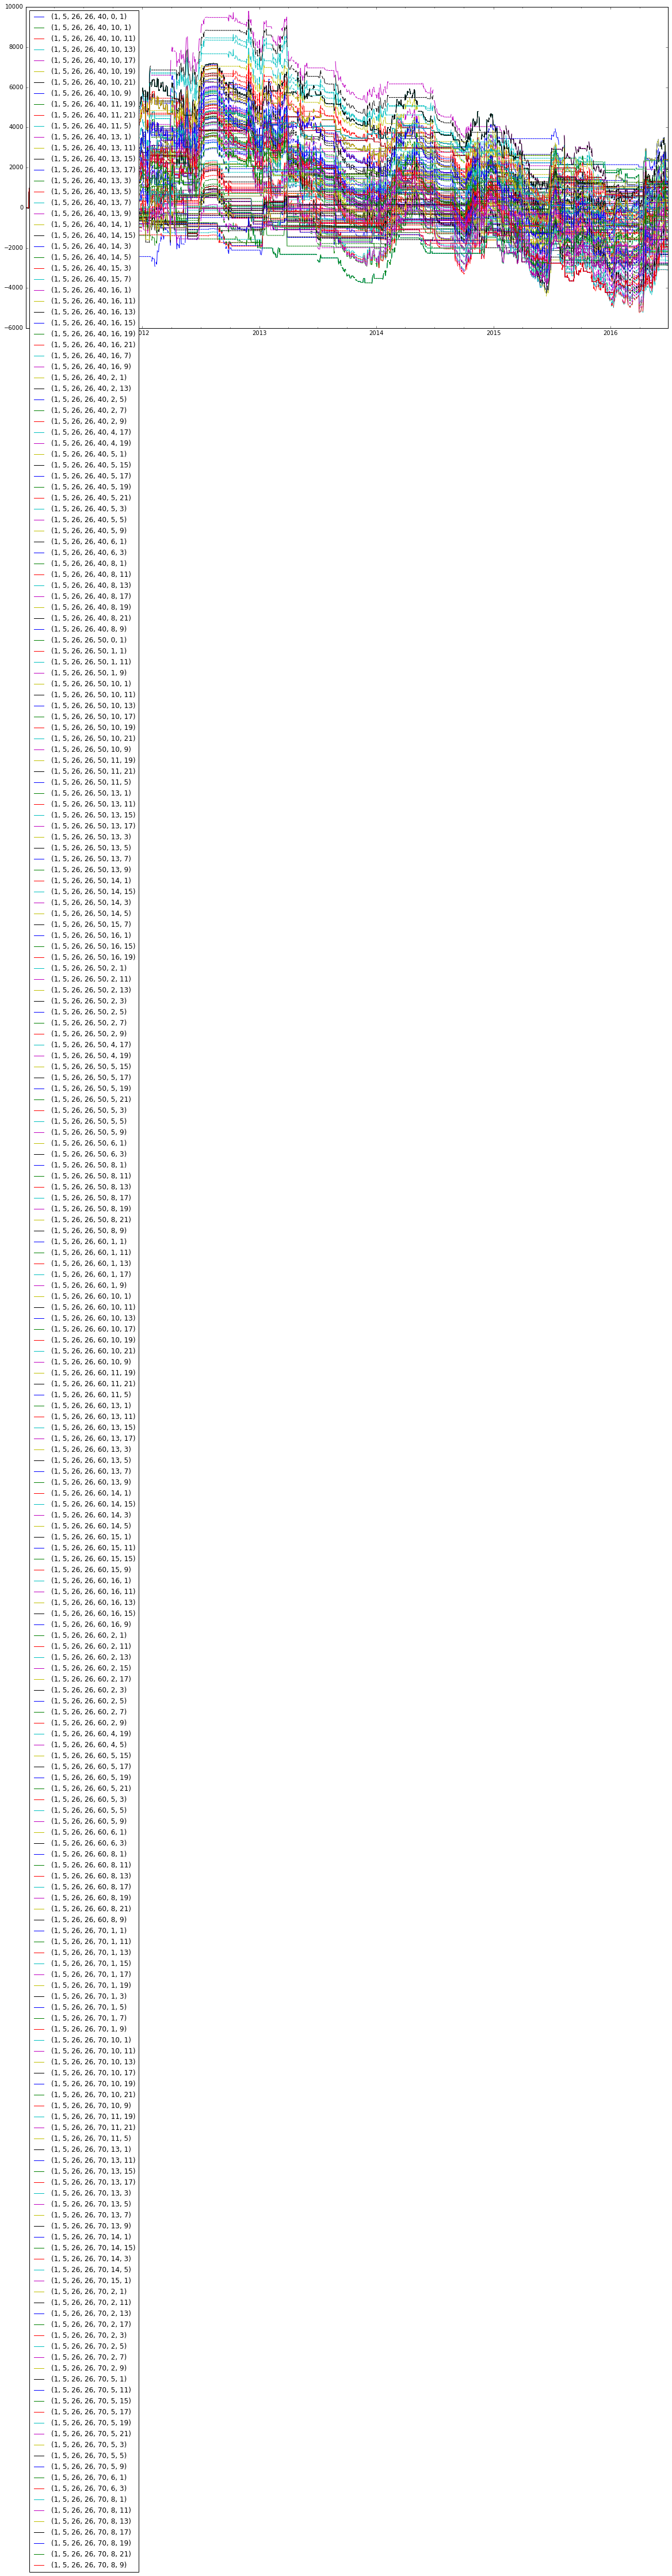

In [50]:
df.plot()

## Filter those strategies by correlation

In [16]:
df.corr()

,"(1, 5, 26, 26, 40, 0, 1)","(1, 5, 26, 26, 40, 10, 1)","(1, 5, 26, 26, 40, 10, 11)","(1, 5, 26, 26, 40, 10, 13)","(1, 5, 26, 26, 40, 10, 17)","(1, 5, 26, 26, 40, 10, 19)","(1, 5, 26, 26, 40, 10, 21)","(1, 5, 26, 26, 40, 10, 9)","(1, 5, 26, 26, 40, 11, 19)","(1, 5, 26, 26, 40, 11, 21)",...,"(1, 5, 26, 26, 70, 5, 9)","(1, 5, 26, 26, 70, 6, 1)","(1, 5, 26, 26, 70, 6, 3)","(1, 5, 26, 26, 70, 8, 1)","(1, 5, 26, 26, 70, 8, 11)","(1, 5, 26, 26, 70, 8, 13)","(1, 5, 26, 26, 70, 8, 17)","(1, 5, 26, 26, 70, 8, 19)","(1, 5, 26, 26, 70, 8, 21)","(1, 5, 26, 26, 70, 8, 9)"
"(1, 5, 26, 26, 40, 0, 1)",1.000000,0.453597,0.384845,0.247806,0.327706,0.379806,0.501927,0.421866,0.324469,0.331880,...,0.118453,0.415454,0.312980,0.453597,0.384845,0.247806,0.327706,0.379806,0.501927,0.421866
"(1, 5, 26, 26, 40, 10, 1)",0.453597,1.000000,0.774309,0.748786,0.805943,0.778115,0.684599,0.815038,0.630610,0.623278,...,0.758798,0.928019,0.875072,1.000000,0.774309,0.748786,0.805943,0.778115,0.684599,0.815038
"(1, 5, 26, 26, 40, 10, 11)",0.384845,0.774309,1.000000,0.961078,0.924249,0.969770,0.947893,0.979750,0.948833,0.950221,...,0.928613,0.811624,0.702253,0.774309,1.000000,0.961078,0.924249,0.969770,0.947893,0.979750
"(1, 5, 26, 26, 40, 10, 13)",0.247806,0.748786,0.961078,1.000000,0.961560,0.970002,0.902335,0.932957,0.936220,0.938405,...,0.946121,0.798440,0.741679,0.748786,0.961078,1.000000,0.961560,0.970002,0.902335,0.932957
"(1, 5, 26, 26, 40, 10, 17)",0.327706,0.805943,0.924249,0.961560,1.000000,0.951723,0.876480,0.940543,0.871065,0.878579,...,0.888297,0.807066,0.738903,0.805943,0.924249,0.961560,1.000000,0.951723,0.876480,0.940543
"(1, 5, 26, 26, 40, 10, 19)",0.379806,0.778115,0.969770,0.970002,0.951723,1.000000,0.959700,0.940226,0.942418,0.940910,...,0.898882,0.812888,0.726850,0.778115,0.969770,0.970002,0.951723,1.000000,0.959700,0.940226
"(1, 5, 26, 26, 40, 10, 21)",0.501927,0.684599,0.947893,0.902335,0.876480,0.959700,1.000000,0.916482,0.945967,0.948841,...,0.810001,0.714946,0.596560,0.684599,0.947893,0.902335,0.876480,0.959700,1.000000,0.916482
"(1, 5, 26, 26, 40, 10, 9)",0.421866,0.815038,0.979750,0.932957,0.940543,0.940226,0.916482,1.000000,0.901017,0.907839,...,0.906225,0.817895,0.692563,0.815038,0.979750,0.932957,0.940543,0.940226,0.916482,1.000000
"(1, 5, 26, 26, 40, 11, 19)",0.324469,0.630610,0.948833,0.936220,0.871065,0.942418,0.945967,0.901017,1.000000,0.997459,...,0.884294,0.709491,0.622710,0.630610,0.948833,0.936220,0.871065,0.942418,0.945967,0.901017
"(1, 5, 26, 26, 40, 11, 21)",0.331880,0.623278,0.950221,0.938405,0.878579,0.940910,0.948841,0.907839,0.997459,1.000000,...,0.882079,0.704997,0.613090,0.623278,0.950221,0.938405,0.878579,0.940910,0.948841,0.907839


In [54]:
corr_df = df.corr()

output_l = []
for i in corr_df.index:
    
    strategy_corr = corr_df[corr_df[i].index != corr_df[i].name][i]
    
    strats_list = (strategy_corr[(strategy_corr >= 0.5)].index.values)
    
    if len(strats_list) != 0:
        
        best_of_high_corr_strats = strategies_performance_df[
            strategies_performance_df.strategy.isin(strats_list)].sort_values('rank_score', ascending=False).strategy.values[0]

        output_l.append(best_of_high_corr_strats)

In [57]:
strategy_corr

(1, 5, 26, 26, 40, 0, 1)      0.421866
(1, 5, 26, 26, 40, 10, 1)     0.815038
(1, 5, 26, 26, 40, 10, 11)    0.979750
(1, 5, 26, 26, 40, 10, 13)    0.932957
(1, 5, 26, 26, 40, 10, 17)    0.940543
(1, 5, 26, 26, 40, 10, 19)    0.940226
(1, 5, 26, 26, 40, 10, 21)    0.916482
(1, 5, 26, 26, 40, 10, 9)     1.000000
(1, 5, 26, 26, 40, 11, 19)    0.901017
(1, 5, 26, 26, 40, 11, 21)    0.907839
(1, 5, 26, 26, 40, 11, 5)     0.754267
(1, 5, 26, 26, 40, 13, 1)    -0.662103
(1, 5, 26, 26, 40, 13, 11)   -0.498185
(1, 5, 26, 26, 40, 13, 15)   -0.611941
(1, 5, 26, 26, 40, 13, 17)    0.138327
(1, 5, 26, 26, 40, 13, 3)    -0.578783
(1, 5, 26, 26, 40, 13, 5)    -0.376353
(1, 5, 26, 26, 40, 13, 7)    -0.369767
(1, 5, 26, 26, 40, 13, 9)    -0.525250
(1, 5, 26, 26, 40, 14, 1)     0.446510
(1, 5, 26, 26, 40, 14, 15)    0.477074
(1, 5, 26, 26, 40, 14, 3)     0.575114
(1, 5, 26, 26, 40, 14, 5)     0.645725
(1, 5, 26, 26, 40, 15, 3)    -0.303387
(1, 5, 26, 26, 40, 15, 7)     0.215522
(1, 5, 26, 26, 40, 16, 1)

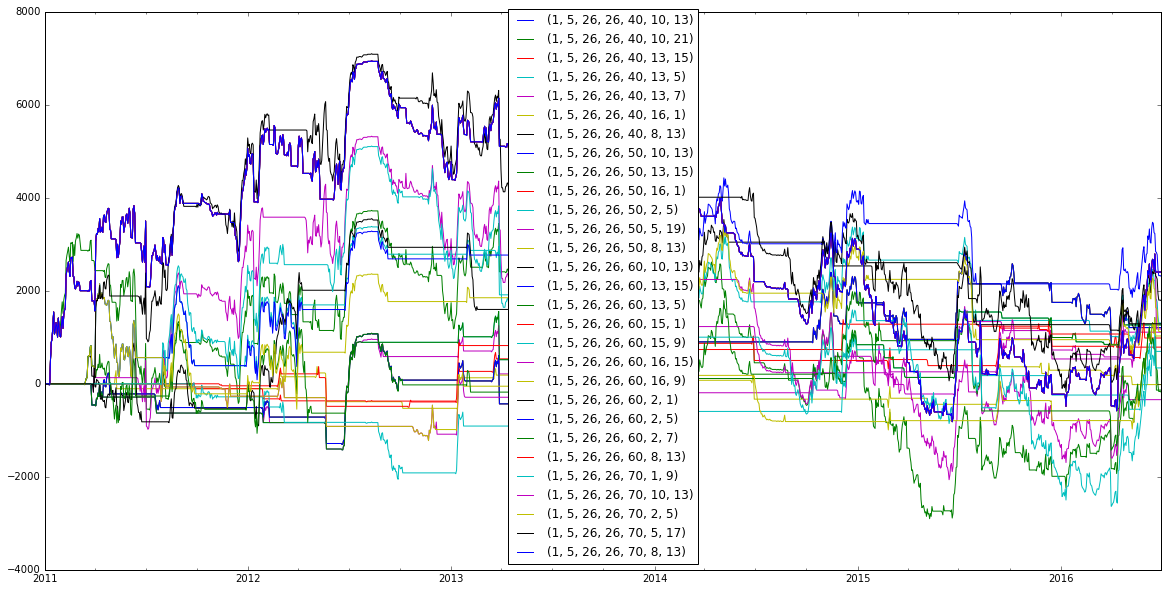

In [55]:
low_corr_strats = pd.Series(output_l).unique()
df[strategies_performance_df[strategies_performance_df.strategy.isin(low_corr_strats)].strategy].dropna().plot()

In [56]:
df[strategies_performance_df[strategies_performance_df.strategy.isin(low_corr_strats)].strategy].dropna().corr()

,"(1, 5, 26, 26, 40, 10, 13)","(1, 5, 26, 26, 40, 10, 21)","(1, 5, 26, 26, 40, 13, 15)","(1, 5, 26, 26, 40, 13, 5)","(1, 5, 26, 26, 40, 13, 7)","(1, 5, 26, 26, 40, 16, 1)","(1, 5, 26, 26, 40, 8, 13)","(1, 5, 26, 26, 50, 10, 13)","(1, 5, 26, 26, 50, 13, 15)","(1, 5, 26, 26, 50, 16, 1)",...,"(1, 5, 26, 26, 60, 16, 9)","(1, 5, 26, 26, 60, 2, 1)","(1, 5, 26, 26, 60, 2, 5)","(1, 5, 26, 26, 60, 2, 7)","(1, 5, 26, 26, 60, 8, 13)","(1, 5, 26, 26, 70, 1, 9)","(1, 5, 26, 26, 70, 10, 13)","(1, 5, 26, 26, 70, 2, 5)","(1, 5, 26, 26, 70, 5, 17)","(1, 5, 26, 26, 70, 8, 13)"
"(1, 5, 26, 26, 40, 10, 13)",1.000000,0.902335,-0.582423,-0.289224,-0.257041,-0.112608,1.000000,1.000000,-0.582423,-0.560245,...,0.169177,0.084524,-0.042039,0.049638,1.000000,0.835819,1.000000,0.047726,0.910479,1.000000
"(1, 5, 26, 26, 40, 10, 21)",0.902335,1.000000,-0.531141,-0.263199,-0.221292,-0.034705,0.902335,0.902335,-0.531141,-0.509493,...,0.306395,0.046496,-0.107149,0.100903,0.902335,0.705902,0.902335,0.047857,0.714045,0.902335
"(1, 5, 26, 26, 40, 13, 15)",-0.582423,-0.531141,1.000000,0.715343,0.706920,-0.180627,-0.582423,-0.582423,1.000000,0.328963,...,-0.312131,0.463273,0.502327,0.394404,-0.582423,-0.241142,-0.582423,0.440404,-0.385734,-0.582423
"(1, 5, 26, 26, 40, 13, 5)",-0.289224,-0.263199,0.715343,1.000000,0.980143,-0.000896,-0.289224,-0.289224,0.715343,0.329444,...,-0.260054,0.401042,0.494130,0.066698,-0.289224,-0.106526,-0.289224,0.418611,-0.183220,-0.289224
"(1, 5, 26, 26, 40, 13, 7)",-0.257041,-0.221292,0.706920,0.980143,1.000000,0.000239,-0.257041,-0.257041,0.706920,0.234093,...,-0.218331,0.309816,0.375092,0.063918,-0.257041,-0.070065,-0.257041,0.314940,-0.173306,-0.257041
"(1, 5, 26, 26, 40, 16, 1)",-0.112608,-0.034705,-0.180627,-0.000896,0.000239,1.000000,-0.112608,-0.112608,-0.180627,0.622659,...,0.513306,-0.424490,-0.270713,-0.507149,-0.112608,-0.435072,-0.112608,-0.348696,-0.209687,-0.112608
"(1, 5, 26, 26, 40, 8, 13)",1.000000,0.902335,-0.582423,-0.289224,-0.257041,-0.112608,1.000000,1.000000,-0.582423,-0.560245,...,0.169177,0.084524,-0.042039,0.049638,1.000000,0.835819,1.000000,0.047726,0.910479,1.000000
"(1, 5, 26, 26, 50, 10, 13)",1.000000,0.902335,-0.582423,-0.289224,-0.257041,-0.112608,1.000000,1.000000,-0.582423,-0.560245,...,0.169177,0.084524,-0.042039,0.049638,1.000000,0.835819,1.000000,0.047726,0.910479,1.000000
"(1, 5, 26, 26, 50, 13, 15)",-0.582423,-0.531141,1.000000,0.715343,0.706920,-0.180627,-0.582423,-0.582423,1.000000,0.328963,...,-0.312131,0.463273,0.502327,0.394404,-0.582423,-0.241142,-0.582423,0.440404,-0.385734,-0.582423
"(1, 5, 26, 26, 50, 16, 1)",-0.560245,-0.509493,0.328963,0.329444,0.234093,0.622659,-0.560245,-0.560245,0.328963,1.000000,...,0.181877,0.038607,0.302471,-0.212041,-0.560245,-0.687943,-0.560245,0.149837,-0.499141,-0.560245


In [158]:
low_corr_strats?

In [108]:
strategy_corr[strategy_corr > 0.5].index.values

array(['(1, 5, 26, 26, 40, 10, 1)', '(1, 5, 26, 26, 40, 10, 11)',
       '(1, 5, 26, 26, 40, 10, 13)', '(1, 5, 26, 26, 40, 10, 15)',
       '(1, 5, 26, 26, 40, 10, 17)', '(1, 5, 26, 26, 40, 10, 19)',
       '(1, 5, 26, 26, 40, 10, 21)', '(1, 5, 26, 26, 40, 10, 5)',
       '(1, 5, 26, 26, 40, 10, 9)', '(1, 5, 26, 26, 40, 11, 17)',
       '(1, 5, 26, 26, 40, 11, 19)', '(1, 5, 26, 26, 40, 11, 21)',
       '(1, 5, 26, 26, 40, 11, 5)', '(1, 5, 26, 26, 40, 14, 1)',
       '(1, 5, 26, 26, 40, 14, 15)', '(1, 5, 26, 26, 40, 14, 3)',
       '(1, 5, 26, 26, 40, 14, 5)', '(1, 5, 26, 26, 40, 14, 9)',
       '(1, 5, 26, 26, 40, 6, 1)', '(1, 5, 26, 26, 40, 6, 3)',
       '(1, 5, 26, 26, 40, 7, 15)', '(1, 5, 26, 26, 40, 7, 19)',
       '(1, 5, 26, 26, 40, 8, 1)', '(1, 5, 26, 26, 40, 8, 11)',
       '(1, 5, 26, 26, 40, 8, 13)', '(1, 5, 26, 26, 40, 8, 15)',
       '(1, 5, 26, 26, 40, 8, 17)', '(1, 5, 26, 26, 40, 8, 19)',
       '(1, 5, 26, 26, 40, 8, 21)', '(1, 5, 26, 26, 40, 8, 5)',
       '(1, 5, 26, 

In [109]:
strategies_performance_df[strategies_performance_df.strategy.isin(strats_list)].sort_values('rank_score', ascending=False).strategy.values[0]

'(1, 5, 26, 26, 40, 8, 13)'

# Metrics calculation

In [16]:
#
# Rebalance triggers
#
# Rebalance trigger must be array of Datetime indexes when event occurred, like date of monday or new month
# 
newmonth = df[df.index.month != df.index.shift(1).month].index

monday = df[df.index.weekday == 0].index

norebalance = [df.index[-1]]

newyear = df[df.index.year != df.index.shift(1).year].index
#
#
#

# note: I think more performance metrics for strategies is better
# https://www.amibroker.com/guide/h_report.html for reference

rebalance_index = 1
rebalance_date_start = None

rebalance_trigger = newyear # set rebalance trigger here

temp_l = []

for reb_idx in rebalance_trigger:
    
    for strat in df.columns:

        if rebalance_index == 1:
            rebalance_date_start = df.index[0]
           
        for i in range(len(df[strat])):

            if df[strat].index[i] == reb_idx:

                input_strategy_data = df[strat].ix[rebalance_date_start:reb_idx] # This data is used in metrics calc
                
                price_change = input_strategy_data.diff()
                max_dd = (input_strategy_data - input_strategy_data.expanding().max()).min()
                netprofit = df[strat].ix[reb_idx] - df[strat].ix[rebalance_date_start]
                
                # Since swarm PnL statistics is not trade-by-trade
                # For PF calc I used cumulative values of positive and negatives price changes
                # Same for winrate
                profit_factor = price_change[price_change > 0].sum() / np.abs(price_change[price_change < 0].sum())
                
                winrate = (price_change[price_change > 0].count() / price_change.count()) * 100               
                # If all trades are negative, PF is 0. But later all 0s is replaced with NaN. 
                # To avoid replacing true 0.0 PF set it to 0.000001
                # This made for handling missing data 
                
                # Also winrate can be 0.0, but if PF is NaN - no trades were made
                # This made for handling missing data 
                
                if winrate == 0.0 and np.isnan(profit_factor) == False:
                    winrate = 0.000001
                
                elif winrate == 0.0 and np.isnan(profit_factor) == True:
                    winrate = np.nan
                                
                if profit_factor == 0.0:
                    profit_factor = 0.000001                
                          
                try:
                    modsharpe = np.mean(price_change) / np.std(price_change)
                    
                except ZeroDivisionError:
                    modsharpe = np.nan
            
                
                d = {'strategy': strat,'rebalance_date_start': rebalance_date_start,
                    'rebalance_date_end': reb_idx, 'rebalance_index': rebalance_index,
                    'stats_pricechange_modsharpe': modsharpe, 
                    'stats_netprofit': netprofit,
                    'stats_max_dd': max_dd, 'stats_recovery_factor': netprofit / np.abs(max_dd),
                    'stats_profit_factor': profit_factor, 'stats_winrate': winrate }
                
                '''
                d = {'strategy': strat,'rebalance_date_start': rebalance_date_start,
                    'rebalance_date_end': reb_idx, 'rebalance_index': rebalance_index,
                    'stats_pricechange_modsharpe': modsharpe, 
                    'stats_recovery_factor': netprofit / np.abs(max_dd)}
                '''
                
                temp_l.append(d)
    
    rebalance_index += 1
    rebalance_date_start = reb_idx # set new start rebalance date to current rebalance trigger date

### Data cleaning

In [17]:
# Replacing 0 values with NaNs
# If strategy stats is 0 means that no trades were made
stats_df = pd.DataFrame(temp_l).replace(0, np.nan)

# Filling NaNs with last avaible values
for s in stats_df.strategy.unique():
    stats_df[stats_df.strategy == s] = stats_df[stats_df.strategy == s].fillna(method='pad')

stats_df = stats_df.dropna(how='any')

In [18]:
stats_df

,rebalance_date_end,rebalance_date_start,rebalance_index,stats_max_dd,stats_netprofit,stats_pricechange_modsharpe,stats_profit_factor,stats_recovery_factor,stats_winrate,strategy
468,2013-12-31,2012-12-31,3,-715.00,1500.50,0.094107,1.957045,2.098601,8.612440,"(1, 5, 26, 26, 40, 0, 1)"
469,2013-12-31,2012-12-31,3,-1042.75,686.00,0.004237,1.023761,0.657876,10.526316,"(1, 5, 26, 26, 40, 10, 1)"
470,2013-12-31,2012-12-31,3,-3497.25,-1738.00,-0.072452,0.755167,-0.496962,26.315789,"(1, 5, 26, 26, 40, 10, 11)"
471,2013-12-31,2012-12-31,3,-3547.25,-1900.50,-0.078206,0.740452,-0.535767,26.315789,"(1, 5, 26, 26, 40, 10, 13)"
472,2013-12-31,2012-12-31,3,-2911.25,-946.50,-0.085087,0.729978,-0.325118,28.708134,"(1, 5, 26, 26, 40, 10, 17)"
473,2013-12-31,2012-12-31,3,-3080.75,-1098.00,-0.087823,0.733658,-0.356407,30.622010,"(1, 5, 26, 26, 40, 10, 19)"
474,2013-12-31,2012-12-31,3,-3256.50,-1273.75,-0.090505,0.729616,-0.391141,31.578947,"(1, 5, 26, 26, 40, 10, 21)"
475,2013-12-31,2012-12-31,3,-3166.75,-1331.00,-0.065496,0.763320,-0.420305,22.966507,"(1, 5, 26, 26, 40, 10, 9)"
476,2013-12-31,2012-12-31,3,-4198.75,-2736.25,-0.107921,0.662337,-0.651682,21.531100,"(1, 5, 26, 26, 40, 11, 19)"
477,2013-12-31,2012-12-31,3,-4343.25,-2880.75,-0.113765,0.649405,-0.663271,21.531100,"(1, 5, 26, 26, 40, 11, 21)"


## Statistics rank calculation

In [21]:
ranks_d = {}
ranks_rebidx_d = {}

for i in stats_df.rebalance_index.unique():

    for col in stats_df[stats_df.rebalance_index == i].columns:
        
        stats_col_flag = False
    
        if 'stats' in col:

            # Define 0-10-20-30-40-50-60-70-80-90-100 quantiles values of certain strategy statistics
            metric_quantile0 = stats_df[col].quantile(0.0)
            metric_quantile10 = stats_df[col].quantile(0.1)
            metric_quantile20 = stats_df[col].quantile(0.2)
            metric_quantile30 = stats_df[col].quantile(0.3)
            metric_quantile40 = stats_df[col].quantile(0.4)
            metric_quantile50 = stats_df[col].quantile(0.5)
            metric_quantile60 = stats_df[col].quantile(0.6)
            metric_quantile70 = stats_df[col].quantile(0.7)
            metric_quantile80 = stats_df[col].quantile(0.8)
            metric_quantile90 = stats_df[col].quantile(0.9)
            metric_quantile100 = stats_df[col].quantile(1)

            stats_col_flag = True

        if stats_col_flag == True:
    
            for strat in stats_df[stats_df.rebalance_index == i].strategy:

                # Define strategy statistics rank of certain strategy

                strategy_stats_metric = stats_df[(stats_df.rebalance_index == i) 
                                                 & (stats_df.strategy == strat)][col].values[0]

                if strategy_stats_metric >= metric_quantile0 and strategy_stats_metric <= metric_quantile10:
                    rank_score = 0

                elif strategy_stats_metric >= metric_quantile10 and strategy_stats_metric <= metric_quantile20:
                    rank_score = 1

                elif strategy_stats_metric >= metric_quantile20 and strategy_stats_metric <= metric_quantile30:
                    rank_score = 2

                elif strategy_stats_metric >= metric_quantile30 and strategy_stats_metric <= metric_quantile40:
                    rank_score = 3

                elif strategy_stats_metric >= metric_quantile40 and strategy_stats_metric <= metric_quantile50:
                    rank_score = 4

                elif strategy_stats_metric >= metric_quantile50 and strategy_stats_metric <= metric_quantile60:
                    rank_score = 5

                elif strategy_stats_metric >= metric_quantile60 and strategy_stats_metric <= metric_quantile70:
                    rank_score = 6

                elif strategy_stats_metric >= metric_quantile70 and strategy_stats_metric <= metric_quantile80:
                    rank_score = 7

                elif strategy_stats_metric >= metric_quantile80 and strategy_stats_metric <= metric_quantile90:
                    rank_score = 8

                elif strategy_stats_metric >= metric_quantile90 and strategy_stats_metric <= metric_quantile100:
                    rank_score = 9

                elif strategy_stats_metric == metric_quantile100:
                    rank_score = 10

                    
                if strat not in ranks_d.keys():               
                    ranks_d[strat] = rank_score
                    
                elif strat in ranks_d.keys():                
                    ranks_d[strat] = ranks_d[strat] + rank_score
            #ranks_d['rebalance_idx_'+str(i)] = i

                    
                # For debugging purposes

                #print('strategy---',strat,'\n')
                #print(col)
                #print('10 quantile---',metric_quantile10)
                #print(strategy_stats_metric)
                #print('60 quantile---',metric_quantile60)
                #print(strategy_stats_metric > metric_quantile40 and strategy_stats_metric < metric_quantile50)
                #print('rank_score------', rank_score, '\n')

    
    print('rebalance index ---', i)
    #break
    for k in ranks_d:

        strat_index = stats_df[(stats_df.strategy == k) & ((stats_df.rebalance_index == i))].index
        #print(strat_index)
        stats_df = stats_df.set_value(strat_index, 'rank_score', ranks_d[k])
        
    ranks_d = {}

rebalance index --- 3
rebalance index --- 4
rebalance index --- 5


In [22]:
stats_df[(stats_df.rebalance_index == 4)].sort_values('rank_score', ascending=False)

,rebalance_date_end,rebalance_date_start,rebalance_index,stats_max_dd,stats_netprofit,stats_pricechange_modsharpe,stats_profit_factor,stats_recovery_factor,stats_winrate,strategy,rank_score
735,2014-12-31,2013-12-31,4,-937.50,2421.50,0.112453,1.564430,2.582933,20.095694,"(1, 5, 26, 26, 40, 2, 1)",49.0
836,2014-12-31,2013-12-31,4,-498.50,2040.50,0.103340,1.757395,4.093280,12.440191,"(1, 5, 26, 26, 60, 13, 9)",49.0
780,2014-12-31,2013-12-31,4,-498.50,2040.50,0.103340,1.757395,4.093280,12.440191,"(1, 5, 26, 26, 50, 13, 9)",49.0
789,2014-12-31,2013-12-31,4,-937.50,2639.50,0.122579,1.639245,2.815467,20.095694,"(1, 5, 26, 26, 50, 2, 1)",49.0
904,2014-12-31,2013-12-31,4,-498.50,2040.50,0.103340,1.757395,4.093280,12.440191,"(1, 5, 26, 26, 70, 13, 9)",49.0
774,2014-12-31,2013-12-31,4,-448.50,2090.50,0.102570,1.751771,4.661093,11.961722,"(1, 5, 26, 26, 50, 13, 11)",49.0
830,2014-12-31,2013-12-31,4,-448.50,2090.50,0.102570,1.751771,4.661093,11.961722,"(1, 5, 26, 26, 60, 13, 11)",49.0
720,2014-12-31,2013-12-31,4,-498.50,2040.50,0.103340,1.757395,4.093280,12.440191,"(1, 5, 26, 26, 40, 13, 9)",49.0
714,2014-12-31,2013-12-31,4,-448.50,2090.50,0.102570,1.751771,4.661093,11.961722,"(1, 5, 26, 26, 40, 13, 11)",49.0
898,2014-12-31,2013-12-31,4,-448.50,2090.50,0.102570,1.751771,4.661093,11.961722,"(1, 5, 26, 26, 70, 13, 11)",49.0


### Strategies picker

In [23]:
# Trade-by-trade pnl
pnl_df = df.diff()

summary_best_eqty = pd.Series()
summary_worst_eqty = pd.Series()
benchmark_eqty = pd.Series()
# We can set start rebalance index value to 
for i in range(stats_df.rebalance_index.unique().min(),stats_df.rebalance_index.unique().max()):
    
    if i < 2:
        # We must estimate strategies preformance at least on one rebalance window
        continue
        
    else:

        # Pick strats from previous rebalance, but trade them until next rebalance
                        
        start_date = stats_df[stats_df.rebalance_index == i].rebalance_date_start.values[0]  
        end_date = stats_df[stats_df.rebalance_index == i].rebalance_date_end.values[0]
        
        # Number of picked strats defined by .strategy.values[:number]
        # Remove -1 from 'i - 1' to get holy grail :D (future reference)
        
        picked_best_strats = stats_df[stats_df.rebalance_index == i - 1].sort_values('rank_score', 
                                                                                ascending=False).strategy.values[:10]
        
        picked_worst_strats = stats_df[stats_df.rebalance_index == i - 1].sort_values('rank_score', 
                                                                                ascending=False).strategy.values[-5:]
        
        all_strats = stats_df[stats_df.rebalance_index == i - 1].sort_values('rank_score', 
                                                                                ascending=False).strategy.values[:]
        
        if len(summary_best_eqty) == 0 and len(summary_worst_eqty) == 0 and len(benchmark_eqty) == 0:
            summary_best_eqty = df[picked_best_strats].ix[start_date : end_date].sum(axis=1)           
            summary_worst_eqty = pnl_df[picked_worst_strats].ix[start_date : end_date].sum(axis=1)
            
            benchmark_eqty = pnl_df[all_strats].ix[start_date : end_date].sum(axis=1)      
            
        else:
            summary_best_eqty = summary_best_eqty.append(pnl_df[picked_best_strats].ix[start_date : end_date].sum(axis=1))
            summary_worst_eqty = summary_worst_eqty.append(pnl_df[picked_worst_strats].ix[start_date : end_date].sum(axis=1))
            
            benchmark_eqty = benchmark_eqty.append(pnl_df[all_strats].ix[start_date : end_date].sum(axis=1))
            
        
best_portfolio = summary_best_eqty.cumsum()
worst_portfolio = summary_worst_eqty.cumsum() * -1 # Reversed

summary_portfolio = best_portfolio + worst_portfolio

benchmark_portfolio = benchmark_eqty.cumsum()

## Comparing portfolios stats with benchmark(all strategies equity)

In [27]:
def portfolio_stats(portfolio_ser,label):
    input_data = portfolio_ser # This data is used in metrics calc
                
    price_change = input_data.diff()
    max_dd = (input_data - input_data.expanding().max()).min()
    netprofit = input_data.ix[input_data.index[-1]] - input_data.ix[input_data.index[0]]

    # Since swarm PnL statistics is not trade-by-trade
    # For PF calc I used cumulative values of positive and negatives price changes
    # Same for winrate
    profit_factor = price_change[price_change > 0].sum() / np.abs(price_change[price_change < 0].sum())

    winrate = (price_change[price_change > 0].count() / price_change.count()) * 100               

    modsharpe = np.mean(price_change) / np.std(price_change)

    recovery_factor = netprofit / np.abs(max_dd)

    print('Portfolio name ---', str(label))
    print('\n')
    print('PriceChange Mod. Sharpe', modsharpe)
    print('Netprofit',netprofit)
    print('Max DD', max_dd)
    print('Recovery Factor', recovery_factor)
    print('Profit factor', profit_factor)
    print('Winrate', winrate)

    input_data.plot(kind='area', stacked=False)

Portfolio name --- Best


PriceChange Mod. Sharpe -0.002473238766521318
Netprofit -4218.25
Max DD -30983.0
Recovery Factor -0.136147242036
Profit factor 0.984583166203
Winrate 11.977102598


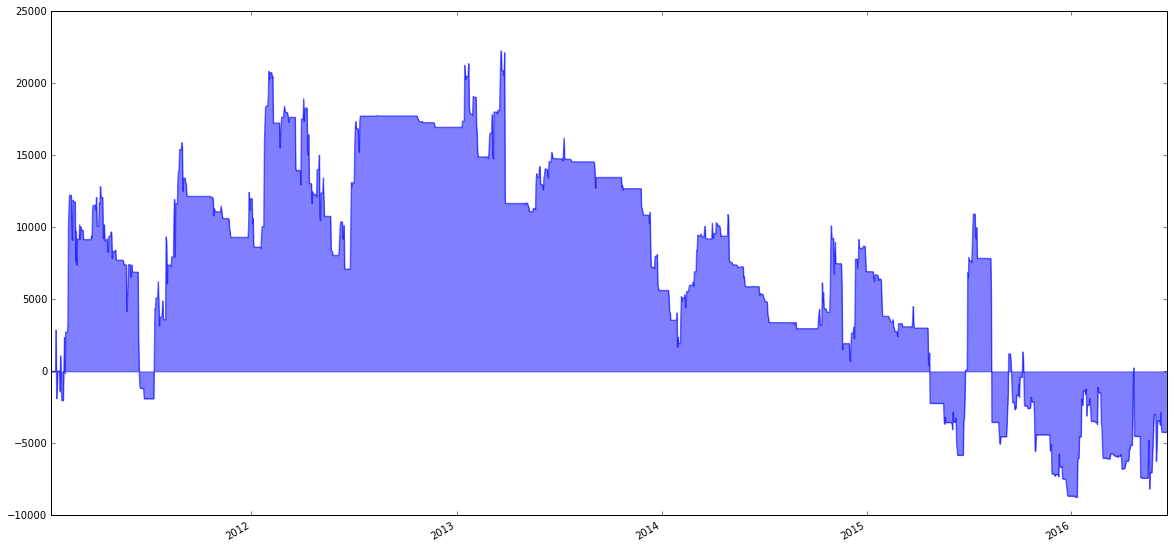

In [28]:
portfolio_stats(best_portfolio, 'Best')

Portfolio name --- Worst(reversed)


PriceChange Mod. Sharpe -0.06386146011882447
Netprofit -13768.5
Max DD -16654.75
Recovery Factor -0.82670109128
Profit factor 0.625290859857
Winrate 8.34473324213


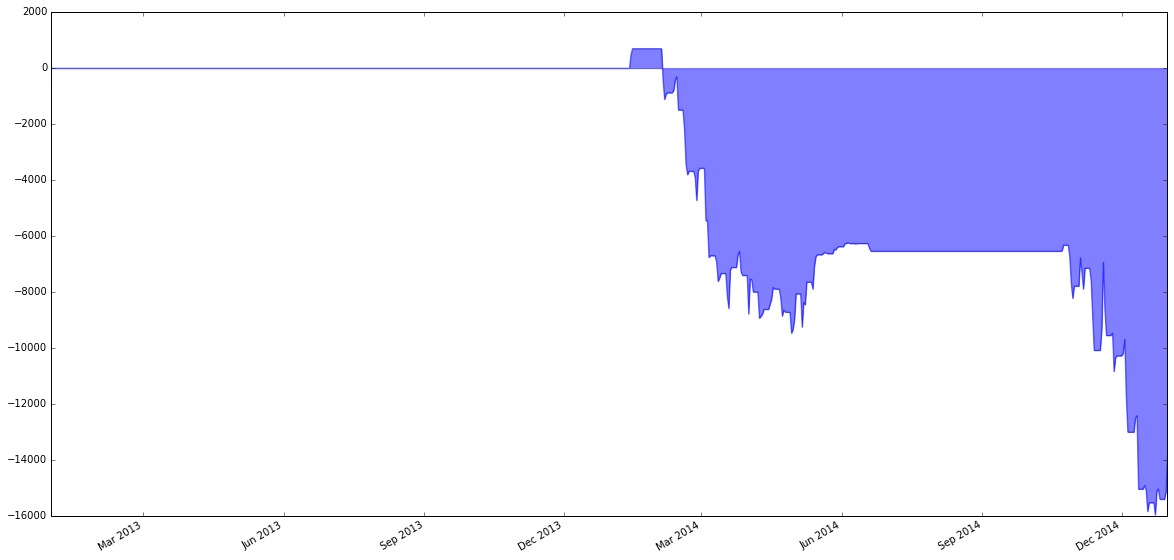

In [45]:
portfolio_stats(worst_portfolio, 'Worst(reversed)')

Portfolio name --- Summary(Best + Worst)


PriceChange Mod. Sharpe -0.06914827164632995
Netprofit -13354.5
Max DD -15862.5
Recovery Factor -0.841891252955
Profit factor 0.602159827214
Winrate 7.7975376197


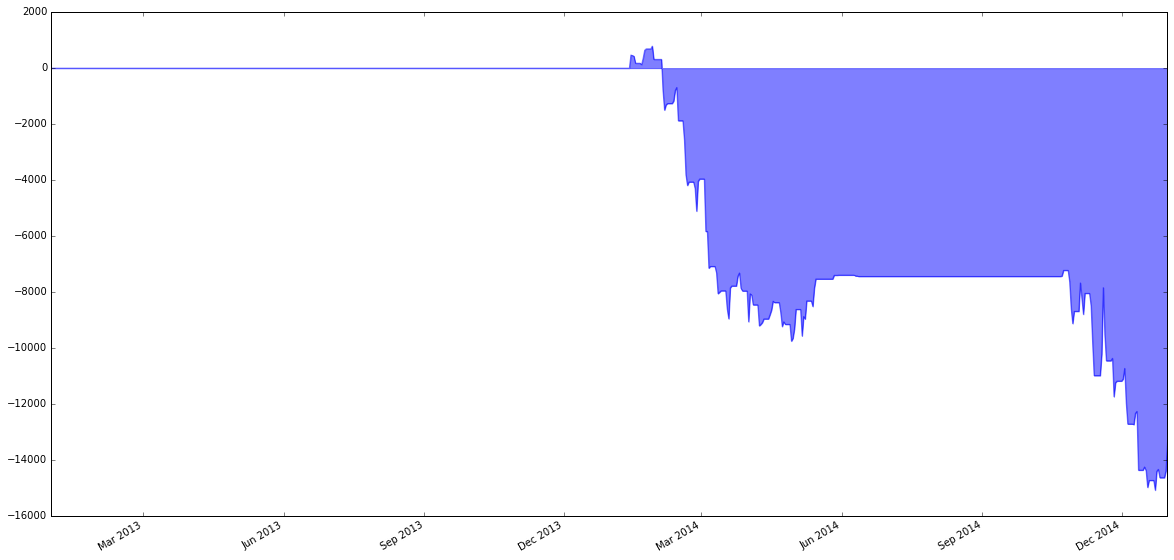

In [46]:
portfolio_stats(summary_portfolio, 'Summary(Best + Worst)')

Portfolio name --- Benchmark


PriceChange Mod. Sharpe 0.03796313917286957
Netprofit 251422.25
Max DD -228422.5
Recovery Factor 1.10068951176
Profit factor 1.23282705185
Winrate 12.4487004104


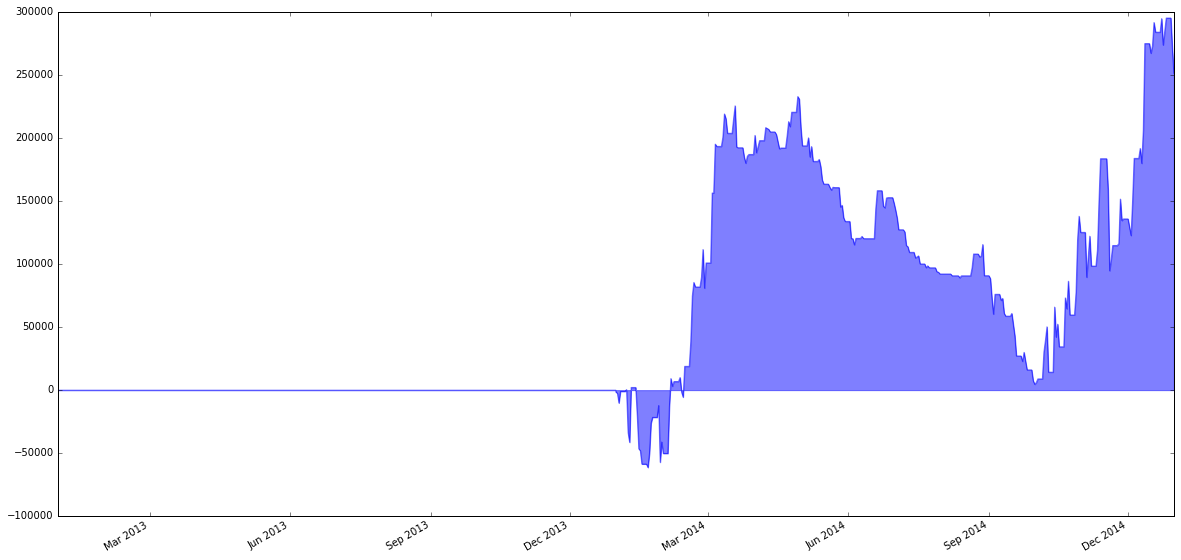

In [47]:
portfolio_stats(benchmark_portfolio, 'Benchmark')